In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import scvi
import scanorama

### Load Data

In [2]:
_5pNA=sc.read_h5ad('ribas/NSCL_NR001_SCRNA_5P_NA_BRAIN_GEX_final_thresh/NSCL_NR001_SCRNA_5P_NA_BRAIN_GEX_final_thresh_cb.h5')

In [3]:
_3pNI=sc.read_h5ad('ribas/NSCL_NR001_SNSEQ_3P_NI_BRAIN_GEX_final_thresh/NSCL_NR001_SNSEQ_3P_NI_BRAIN_GEX_final_thresh_cb.h5')

In [4]:
_3pWI=sc.read_h5ad('ribas/NSCL_NR001_SNSEQ_3P_WI_BRAIN_GEX_final_thresh/NSCL_NR001_SNSEQ_3P_WI_BRAIN_GEX_final_thresh_cb.h5')

In [5]:
_5pNI=sc.read_h5ad('ribas/NSCL_NR001_SNSEQ_5P_NI_BRAIN_GEX_final_thresh/NSCL_NR001_SNSEQ_5P_NI_BRAIN_GEX_final_thresh_cb.h5')

In [6]:
_5pWI=sc.read_h5ad('ribas/NSCL_NR001_SNSEQ_5P_WI_BRAIN_GEX_final_thresh/NSCL_NR001_SNSEQ_5P_WI_BRAIN_GEX_final_thresh_cb.h5')

In [7]:
_5pv2=sc.read_h5ad('ribas/NSCL-NR001-5pv2-snseq_final_thresh/NSCL-NR001-5pv2-snseq_final_thresh_cb.h5')

In [40]:
NSCL_merged=_5pNA.concatenate(_3pNI,_3pWI,_5pNI,_5pWI,_5pv2)

In [6]:
#NSCL_merged=_5pNA.concatenate(_5pNI,_5pWI,_5pv2)

In [13]:
#save a copy of counts for scvi (from tutorial)
NSCL_merged.layers["counts"] = NSCL_merged.X.copy()

In [14]:
#normalize + log transform using scanpy

#NORMALIZATION AND LOG TRANSFORM
sc.pp.calculate_qc_metrics(NSCL_merged, inplace=True)

# UPDATE OBS WITH USE

# store the current 'total_counts' under original_total_counts, which will not automatically be updated
# by scanpy in subsequent filtering steps
NSCL_merged.obs['original_total_counts'] = NSCL_merged.obs['total_counts']

# log10 original library size
NSCL_merged.obs['log10_original_total_counts'] = np.log10(NSCL_merged.obs['original_total_counts'])

# Normalize by median library size
med = np.median(NSCL_merged.obs['original_total_counts'])
sc.pp.normalize_per_cell(NSCL_merged, counts_per_cell_after = med)

#log transform + 1 and updates adata.X
sc.pp.log1p(NSCL_merged)

In [15]:
sc.pp.highly_variable_genes(
    NSCL_merged,
    n_top_genes=8000,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
    batch_key="orig.ident"
)

In [37]:
sc.pp.neighbors(NSCL_merged)

In [38]:
sc.tl.umap(NSCL_merged)

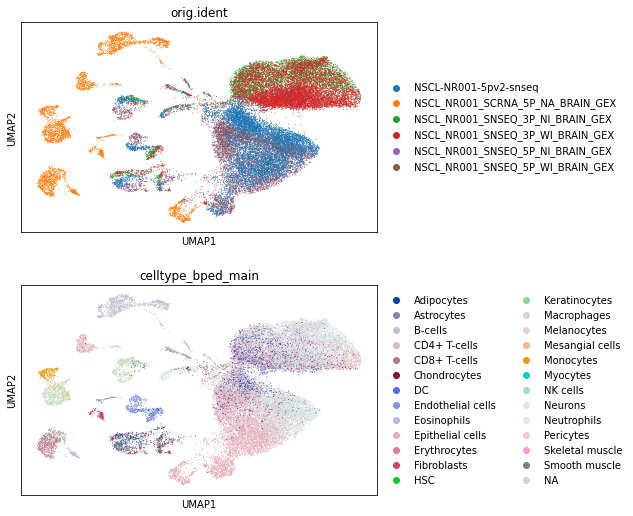

In [39]:
sc.pl.umap(NSCL_merged, color=['orig.ident','celltype_bped_main'],ncols=1,save="NSCL_full_no_batch.png")

In [41]:
pd.DataFrame(NSCL_merged.obsm["X_umap"]).to_csv("ribas/NSCL/NSCL_full_raw_umap.csv")

In [42]:
from sklearn.decomposition import PCA
X = NSCL_merged.to_df().to_numpy()
pca = PCA(n_components=20)
pcs = pca.fit_transform(X)

#pd.DataFrame(pcs).to_csv("ribas/NSCL/NSCL_5p_merged_NO_BATCH_pcs.csv")

In [43]:
df=NSCL_merged.to_df()
df.columns=NSCL_merged.var_names
#df.to_csv("ribas/NSCL/NSCL_5p_no_batch_dense.csv")

### SCVI

In [11]:
## DO WE NEED GENE FILTERING??

In [22]:
scvi.data.setup_anndata(NSCL_merged, layer="counts", batch_key="orig.ident")

INFO     Using batches from adata.obs["orig.ident"]                                          
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 33418 cells, 8000 vars, 6 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


In [23]:
vae = scvi.model.SCVI(NSCL_merged, n_layers=2, n_latent=30)
vae.train()

INFO     Training for 239 epochs                                                             
INFO     KL warmup phase exceeds overall training phaseIf your applications rely on the      
         posterior quality, consider training for more epochs or reducing the kl warmup.     
INFO     KL warmup for 400 epochs                                                            
Training...: 100%|██████████| 239/239 [3:39:28<00:00, 55.10s/it]  
INFO     Training is still in warming up phase. If your applications rely on the posterior   
         quality, consider training for more epochs or reducing the kl warmup.               
INFO     Training time:  13168 s. / 239 epochs                                               


In [24]:
NSCL_merged.obsm["X_scVI"] = vae.get_latent_representation()

In [25]:
vae.save("ribas/NSCL/NSCL_full_scvi_model.weights")

In [44]:
# use scVI latent space for UMAP generation
sc.pp.neighbors(NSCL_merged, use_rep="X_scVI")

In [45]:
sc.tl.umap(NSCL_merged)

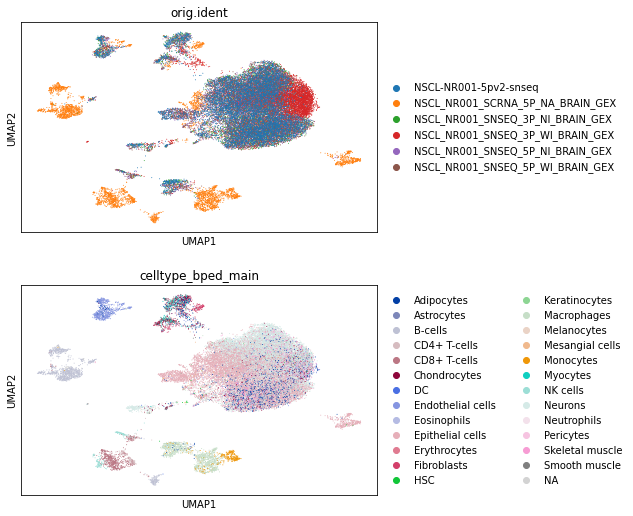

In [46]:
sc.pl.umap(NSCL_merged, color=["orig.ident","celltype_bped_main"],ncols=1)

In [47]:
pd.DataFrame(NSCL_merged.obsm["X_umap"]).to_csv("ribas/NSCL/NSCL_full_scvi_latent_umap.csv")

In [60]:
pd.DataFrame(NSCL_merged.obsm["X_scVI"]).to_csv("ribas/NSCL/NSCL_full_scvi_latent_components.csv")

In [48]:
from sklearn.decomposition import PCA
X = NSCL_merged.obsm['X_scVI']
pca = PCA(n_components=20)
pcs = pca.fit_transform(X)

pd.DataFrame(pcs).to_csv("ribas/NSCL/NSCL_full_scvi_latent_pcs.csv")

In [12]:
pcs.shape

(33418, 20)

In [25]:
#NSCL_merged=sc.read_h5ad("./ribas/NSCL_SCVI_MERGED.h5")

In [26]:
#test=scvi.model.SCVI.load("ribas/NSCL_scvi_model.weights",NSCL_merged)

In [30]:
#with reconstructed gene space for UMAP (averaged across all batch transforms)
batch_norm=[]
for i in np.unique(NSCL_merged.obs["orig.ident"]):
    print(i)
    batch_norm.append(vae.get_normalized_expression(transform_batch=i))

NSCL-NR001-5pv2-snseq
NSCL_NR001_SCRNA_5P_NA_BRAIN_GEX
NSCL_NR001_SNSEQ_3P_NI_BRAIN_GEX
NSCL_NR001_SNSEQ_3P_WI_BRAIN_GEX
NSCL_NR001_SNSEQ_5P_NI_BRAIN_GEX
NSCL_NR001_SNSEQ_5P_WI_BRAIN_GEX


In [13]:
NSCL_merged.layers["scvi_normalized"]=np.mean(np.asarray(batch_norm),axis=0)

NameError: name 'batch_norm' is not defined

In [17]:
normed = sc.AnnData(NSCL_merged.layers["scvi_normalized"])

In [18]:
normed=sc.AnnData(NSCL_merged.layers["scvi_normalized"])

In [19]:
normed.obs["sample"]=list(NSCL_merged.obs["orig.ident"])
normed.obs["celltype"]=list(NSCL_merged.obs["celltype_bped_main"])

In [20]:
sc.pp.neighbors(normed)

         Falling back to preprocessing with `sc.pp.pca` and default params.


In [21]:
sc.tl.umap(normed)

... storing 'sample' as categorical
... storing 'celltype' as categorical


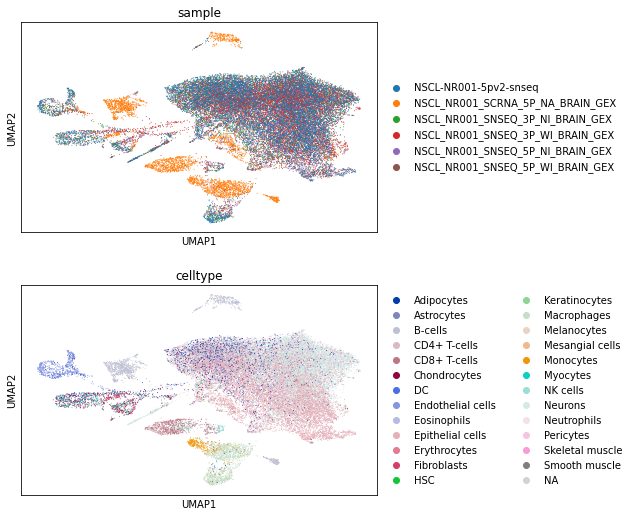

In [22]:
sc.pl.umap(normed,color=["sample", "celltype"],ncols=1)

In [23]:
normed_df=normed.to_df()
normed_df.columns=NSCL_merged.var_names
normed_df.to_csv("ribas/NSCL/NSCL_full_scvi_dense.csv")

In [24]:
from sklearn.decomposition import PCA
X = normed.to_df().to_numpy()
pca = PCA(n_components=20)
pcs = pca.fit_transform(X)

pd.DataFrame(pcs).to_csv("ribas/NSCL/NSCL_full_scvi_dense_pcs.csv")

In [32]:
pd.DataFrame(normed.obsm["X_umap"]).to_csv("ribas/NSCL/NSCL_full_scvi_dense_umap.csv")

In [38]:
NSCL_merged.write_h5ad("./ribas/NSCL/NSCL_full_SCVI_MERGED.h5")

In [58]:
NSCL_merged=sc.read_h5ad("./ribas/NSCL/NSCL_full_SCVI_MERGED.h5")

In [37]:
#normed_df=normed.to_df()
#normed_df.columns=NSCL_merged.var_names
#normed_df.to_csv("ribas/NSCL_SCVI_5p.csv")

In [38]:
#pd.DataFrame(tmp.obsm["X_umap"]).to_csv("ribas_NSCL_5p_scvi_latent_umap.csv")

In [39]:
pd.DataFrame(normed.obsm["X_umap"]).to_csv("ribas/NSCL/NSCL_full_scvi_dense_umap.csv")

In [40]:
#pd.DataFrame(tmp.obs["orig.ident"]).to_csv("ribas/NSCL_SCVI_5p_orig.ident.csv")

### Scanorama

In [4]:
# split per batch into new objects.
batches = NSCL_merged.obs['orig.ident'].cat.categories.tolist()

NSCL_list = {}
for batch in batches:
    NSCL_list[batch] = NSCL_merged[NSCL_merged.obs['orig.ident'] == batch,]

NSCL_list=list(NSCL_list.values())

corrected = scanorama.correct_scanpy(NSCL_list,return_dimred=True)

corrected_merge=corrected[0].concatenate(corrected[1],corrected[2],corrected[3],corrected[4],corrected[5])

In [10]:
#genes=NSCL_merged.var_names

In [11]:
#NSCL_list=[_5pNA[:,genes],_3pNI[:,genes],_3pWI[:,genes],_5pNI[:,genes],_5pWI[:,genes],_5pv2[:,genes]]

In [20]:
#scanorama.integrate_scanpy(NSCL_list)

Found 8000 genes among all datasets
[[0.         0.00828586 0.29637603 0.06824531 0.68285563 0.47681123]
 [0.         0.         0.00336613 0.0046608  0.09321595 0.07638529]
 [0.         0.         0.         0.86257625 0.0920913  0.03284031]
 [0.         0.         0.         0.         0.10323779 0.03258962]
 [0.         0.         0.         0.         0.         0.83178742]
 [0.         0.         0.         0.         0.         0.        ]]
Processing datasets (2, 3)
Processing datasets (4, 5)
Processing datasets (0, 4)
Processing datasets (0, 5)
Processing datasets (0, 2)
Processing datasets (3, 4)


In [45]:
corrected_merge

AnnData object with n_obs × n_vars = 33418 × 8000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'patient', 'ScrubDoublet', 'ScrubDoublet_score', 'RNA_snn_res.0.8', 'seurat_clusters', 'celltype_bped_main', 'celltype_bped_fine', 'celltype_iced_main', 'celltype_iced_fine', 'celltype_hpca_main', 'celltype_hpca_fine', 'celltype_mid_main', 'celltype_mid_fine', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'original_total_counts', 'log10_original_total_counts', 'n_counts', '_scvi_batch', '_scvi_labels', '_scvi_local_l_mean', '_scvi_local_l_var'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    obsm: 'X_pca', 'X_sc

In [46]:
sc.pp.neighbors(corrected_merge,use_rep='X_scanorama')
sc.tl.umap(corrected_merge)

... storing 'orig.ident' as categorical
... storing 'patient' as categorical
... storing 'celltype_bped_main' as categorical
... storing 'celltype_bped_fine' as categorical
... storing 'celltype_iced_fine' as categorical
... storing 'celltype_hpca_main' as categorical
... storing 'celltype_hpca_fine' as categorical
... storing 'celltype_mid_main' as categorical
... storing 'celltype_mid_fine' as categorical


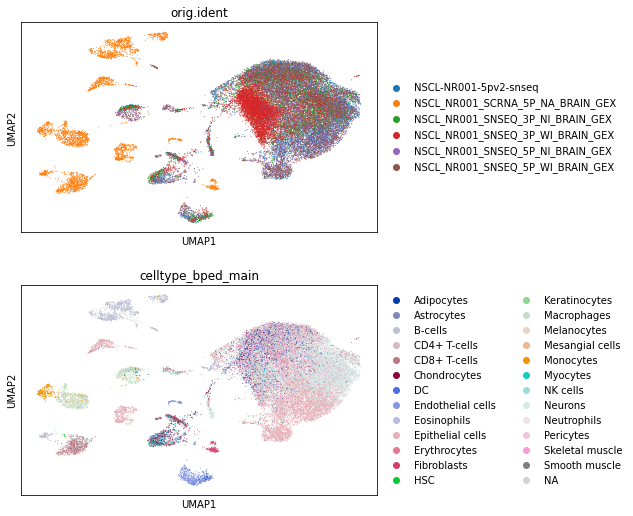

In [48]:
sc.pl.umap(corrected_merge,color=["orig.ident","celltype_bped_main"],ncols=1)

In [49]:
pd.DataFrame(corrected_merge.obsm["X_umap"]).to_csv("ribas/NSCL/NSCL_full_scanorama_latent_umap.csv")
pd.DataFrame(corrected_merge.obsm["X_scanorama"]).to_csv("ribas/NSCL/NSCL_full_scanorama_latent_components.csv")

In [51]:
sc.pp.neighbors(corrected_merge)

In [52]:
sc.tl.umap(corrected_merge)

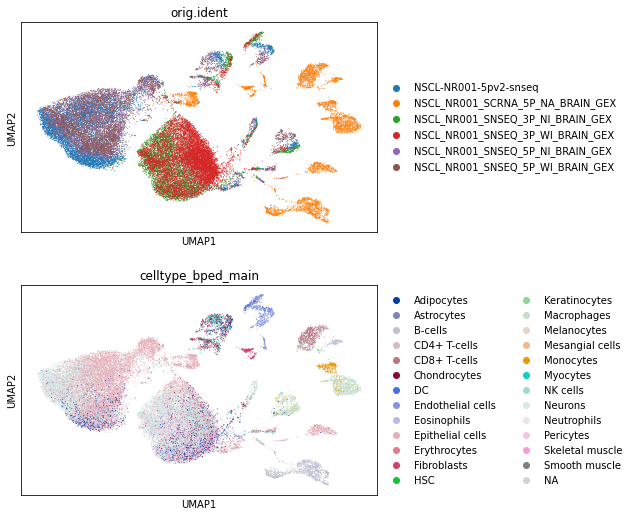

In [53]:
sc.pl.umap(corrected_merge,color=["orig.ident","celltype_bped_main"],ncols=1)

In [54]:
df=corrected_merge.to_df()
df.columns=NSCL_merged.var_names
df.to_csv("ribas/NSCL/NSCL_full_scanorama_dense.csv")

In [55]:
from sklearn.decomposition import PCA
X = corrected_merge.to_df().to_numpy()
pca = PCA(n_components=20)
pcs = pca.fit_transform(X)

pd.DataFrame(pcs).to_csv("ribas/NSCL/NSCL_full_scanorama_pcs.csv")

In [49]:
a=NSCL_merged.obs["orig.ident"]
b=corrected_merge.obs["orig.ident"]

for i in range(len(a)):
    if a[i]!=b[i]:
        print("AAAAAA")

In [56]:
corrected_merge.write_h5ad("ribas/NSCL/NSCL_full_SCANORAMA.h5")

In [57]:
pd.DataFrame(corrected_merge.obsm["X_umap"]).to_csv("ribas/NSCL/NSCL_full_scanorama_dense_umap.csv")

In [55]:
#corrected_merge.to_df().to_csv("ribas/NSCL_SCANORAMA.csv")

In [56]:
pd.DataFrame(NSCL_merged.var_names).to_csv("ribas/NSCL/NSCL_full_hvg_list.csv",header=False,index=False)

In [58]:
pd.DataFrame(NSCL_merged.obs["orig.ident"]).to_csv("ribas/NSCL/NSCL_full_orig.ident.csv")